# Motivation for FDTrees
This tutorial introduces the root cause of disagreements between post-hoc explanation methods : 
**feature interactions**. Moreover, we demonstrate how to minimize the strength of feature interactions ( equivalently increasing agreement between explanations ) with a methodology called
*Functional Decomposition Trees* (FD-Trees for short)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shap
from shap.maskers import Independent

from pyfd.features import Features
from pyfd.fd_trees import CoE_Tree, PDP_PFI_Tree, GADGET_PDP
from pyfd.decompositions import get_components_brute_force, get_PDP_PFI_importance, get_regional_decompositions
from pyfd.shapley import get_SHAP_importance
from pyfd.plots import bar, attrib_scatter_plot, plot_legend, COLORS

 We first generate toy data following $x_i \sim U(-1, 1)$ for $i=1, 2, 3, 4, 5$
 and $$h(x)=
   \begin{cases}
         x_1 & \text{if  } x_2\geq 0\\
         x_3 & \text{otherwise},
   \end{cases}$$

In [2]:
np.random.seed(42)
d = 5
latex_feature_names = ["x_1", "x_2", "x_3", "x_4", "x_5"]
X = np.random.uniform(-1, 1, size=(1000, d))
features = Features(X, latex_feature_names, ["num"]*d)
def h(X):
    y_hat = np.zeros((X.shape[0]))
    mask = (X[:, 1] > 0)
    y_hat[mask] = X[mask, 0]
    y_hat[~mask] = X[~mask, 2]
    return y_hat
y = h(X)

The typical `PyFD` pipeline employs the whole dataset (or a random subsample) as the background distribution $\mathcal{B}$ of the Interventional Decomposition. We first compute the main effects $h_{i,\mathcal{B}}$ of the decomposition.

In [3]:
# Use model agnostic algorithms to decompose the model
decomposition = get_components_brute_force(h, X, X, features)

print(decomposition.keys())

dict_keys([(), (0,), (1,), (2,), (3,), (4,)])


We can also compute Shapley values to provide local attribution scores that sum to the gap $h(x) - \mathbb{E}_{z\sim\mathcal{B}}[h(z)]$.

In [4]:
# Run SHAP on whole dataset
background = X
masker = Independent(background, max_samples=background.shape[0])
explainer = shap.explainers.Exact(h, masker)
shapley_values = explainer(background).values
print(shapley_values.shape)

(1000, 5)


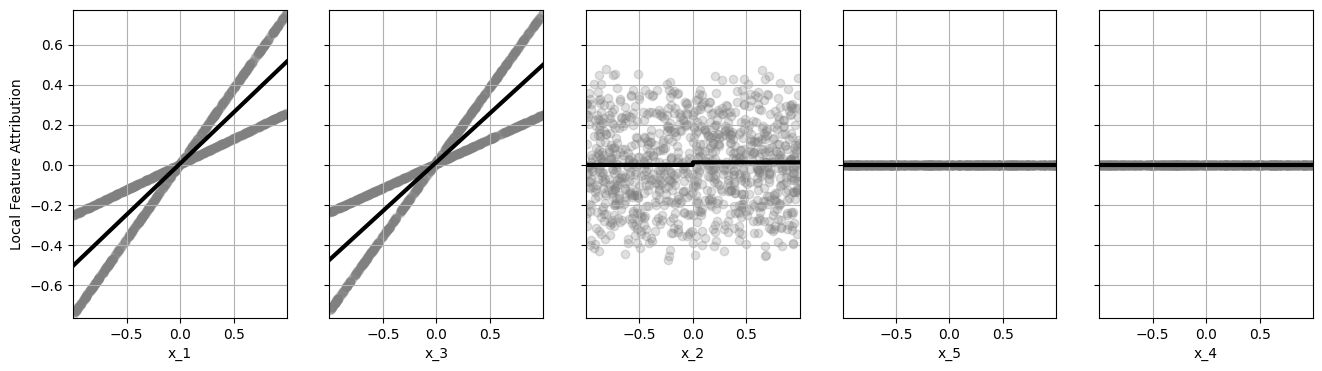

In [5]:
# The main effects (also called PDP) can be plotted along-side the Shapley values
attrib_scatter_plot(decomposition, shapley_values, X, features, figsize=(16, 4))

In this plot, the black lines are the PDP while the grey points are the SHAP values. We observe strong disagreements between PDP and SHAP. In fact, the PDP of $x_2$ is a flat
function while the Shapley values of this feature are all over the place. This disagreement also translates to the PDP/SHAP/PFI global feature importance.

Text(0.5, 23.52222222222222, 'Global Feature Importance')

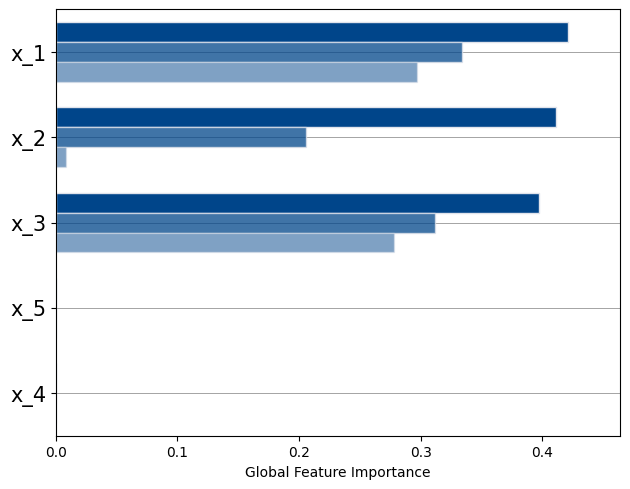

In [6]:
# Global feature importance
I_PDP, I_PFI  = get_PDP_PFI_importance(decomposition)
I_SHAP = get_SHAP_importance(shapley_values)
bar([I_PFI, I_SHAP, I_PDP], features.names())
plt.yticks(fontsize=15)
plt.xlabel("Global Feature Importance")

The importance of $x_2$ is uncertain because different explanation techniques give it vastly different importance. PDP gives it not importance, SHAP ranks
it third, while PFI ranks it second. But what is the source of this disagreement? The key is to express the explanability methods in terms of the
Interventional Decomposition. It can be shown that the following holds.

<p align="center">
    <img src="https://raw.githubusercontent.com/gablabc/PyFD/master/docs/Images/unification.png" width=500 >
</p>

That is, the PDP/SHAP/PFI are different algorithms to explain the Gap $h(x) - \mathbb{E}_{z\sim\mathcal{B}}[h(z)]$. PDP explains this Gap by simply returning the main effect $h_{i,\mathcal{B}}$. PFI explains the Gap by 
accounting for all interactions $h_{u,\mathcal{B}}$ that involve $i$ ($i\in u$). Finally, SHAP is a middle
ground between the two others : SHAP accounts for all interactions involving feature $i$, but it shares the $u$-way interactions evenly between the $|u|$ features involved.

Now, what would happen if there were no feature interactions : $h_{u,\mathcal{B}}(x_u)=0$ whenever $|u| \geq 2$? *Then all methods would yield the same answer!* Consequently, to increase alignment among the PDP/SHAP/PFI methods, we must reduce the strength of feature interactions. There is no universal way to quantify
interactions so `PyFD` supports a variety of Lack of Additivity (LoA) functions $L_h(\mathcal{B})$ that report the strength of interactions in model $h$ relative to the background distribution $\mathcal{B}$.

1. The Cost of Exclusion (CoE) $L^{\text{CoE}}_h(\mathcal{B})=\mathbb{E}_{x\sim\mathcal{B}}[\,(h(x) - \sum_{u\subseteq [d]:|u|\leq 1} h_{u,\mathcal{B}}(x_u))^2\,]$
reports the squared error between the model and its additive Interventional Decomposition.
2. The PDP-PFI score $L^{\text{PDP-PFI}}_h(\mathcal{B}) = \mathbb{E}_{x\sim \mathcal{B}}[ \|\phi^{\text{PDP}}(h, x) - \phi^{\text{PFI}}(h, x)\|^2]$ reports the disagreement between the
PDP and PFI local feature attributions.
3. The GADGET-PDP is another LoA which is too complicated to be explained in a single notebook. We refer the interested reader to the original GADGET-PDP
paper [Here](https://arxiv.org/abs/2306.00541).

Once a LoA score has been chosen, we aim to minimize this score by partitioning the input space into regions $(\Omega_1, \Omega_2, \ldots, \Omega_M)$ such that the
LoAs $L_h(\mathcal{B}_{\Omega})$ are small whenever we restrict the background $\mathcal{B}$ any region $\Omega$ (leading to a regional distribution $\mathcal{B}_{\Omega}$).

LoA 0.5044
Samples 1000
If x_2 ≤ 0.0172:
|   LoA 0.0182
|   Samples 500
|   Region 0
else:
|   LoA 0.0000
|   Samples 500
|   Region 1
Final LoA 0.0182


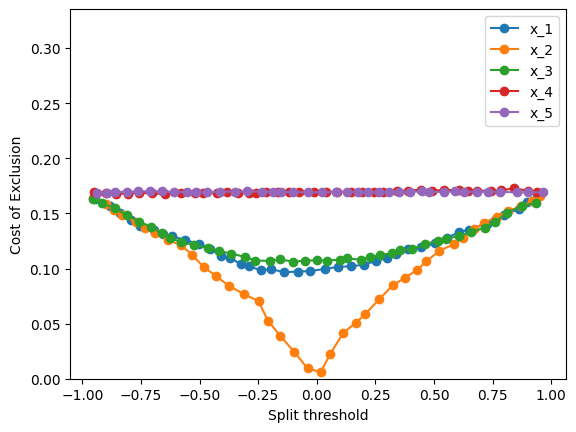

In [7]:
# Choose any LoA function (CoE, PDP-PFI, GADGET-PDP)
tree = CoE_Tree(features, max_depth=1, save_losses=True)
# tree = PDP_PFI_Tree(features, max_depth=1, save_losses=True)
# tree = GADGET_PDP(features, max_depth=1, save_losses=True)
tree.fit(X, decomposition)
# Print results
tree.print(verbose=True)

# Plot the objective values w.r.t the split candidates
plt.figure()
for i in range(5):
    splits = tree.root.splits[i]
    objectives = tree.root.objectives[i]
    plt.plot(splits, objectives, '-o', label=latex_feature_names[i])
plt.ylim(0, y.var())
plt.xlabel("Split threshold")
if isinstance(tree, CoE_Tree):
    plt.ylabel("Cost of Exclusion")
elif isinstance(tree, PDP_PFI_Tree):
    plt.ylabel("Disagreements between PFI and PDP")
elif isinstance(tree, GADGET_PDP):
    plt.ylabel("GADGET-PDP")
plt.legend()

We see that the optimal split separates the instances with positive and negative value of $x_2$ leading to 
regions $\Omega_- = \{x:x_2\leq 0.017\}$ and $\Omega_+ = \{x:x_2>0.017\}$. When restricting the 
background $\mathcal{B}$ to each region (leading to regional distributions $\mathcal{B}_{\Omega_-}$ 
and $\mathcal{B}_{\Omega_+}$), the amplitude of interactions is almost null. Consequently, the PDP/SHAP/PFI 
methods should have increased agreement when restricted to each region.

The method `.predict()` returns the region index for each datum. Moreover, the `.rules()` method returns an interpretable representation of the regions.

In [8]:
regions = tree.predict(X)
print(regions[:10])
n_regions = tree.n_regions
rules = tree.rules()
print(rules)

[1 0 1 0 0 0 0 0 0 0]
{0: 'x_2<=0.02', 1: 'x_2>0.02'}


To compute regional decomposition, we do not need to rerun `PyFD` from scratch, we can run the `get_regional_decompositions`.

In [ ]:
regional_decompositions = get_regional_decompositions(decomposition, regions, regions, n_regions)
del decomposition
# This is a list of decomposition (a list of dict)
print(regional_decompositions)

 We must iterate over each regions to get the regional feature importance

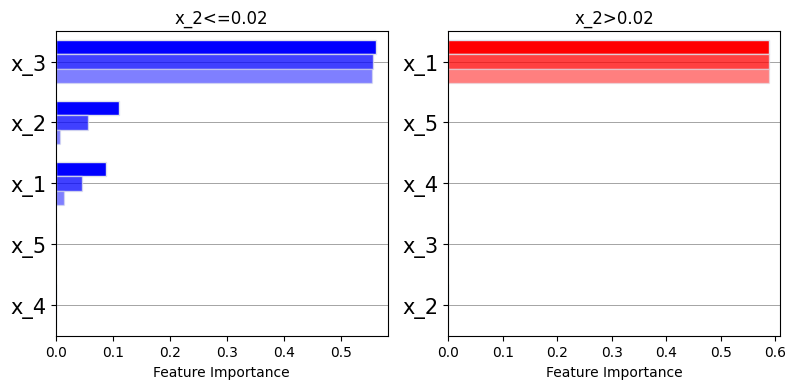

In [10]:
fig, axes = plt.subplots(1, tree.n_regions, figsize=(8, 4))
# Rerun SHAP and recompute global importance regionally
regional_shapley_values = [0] * tree.n_regions
regional_backgrounds = [0] * tree.n_regions
for r in range(tree.n_regions):
    regional_backgrounds[r] = X[regions == r]

    I_PDP, I_PFI = get_PDP_PFI_importance(regional_decompositions[r])

    # We must rerun SHAP
    masker = Independent(regional_backgrounds[r], max_samples=regional_backgrounds[r].shape[0])
    explainer = shap.explainers.Exact(h, masker)
    regional_shapley_values[r] = explainer(regional_backgrounds[r]).values
    I_SHAP = get_SHAP_importance(regional_shapley_values[r])

    bar([I_PFI, I_SHAP, I_PDP], features.names(), ax=axes[r], color=COLORS[r])
    axes[r].set_xlim(0, np.max(I_PFI)+0.02)
    axes[r].set_xlabel("Feature Importance")
    axes[r].set_title(rules[r])

Observe the almost perfect agreement between PDP/SHAP/PFI. Finally, we recompare the local feature attributions

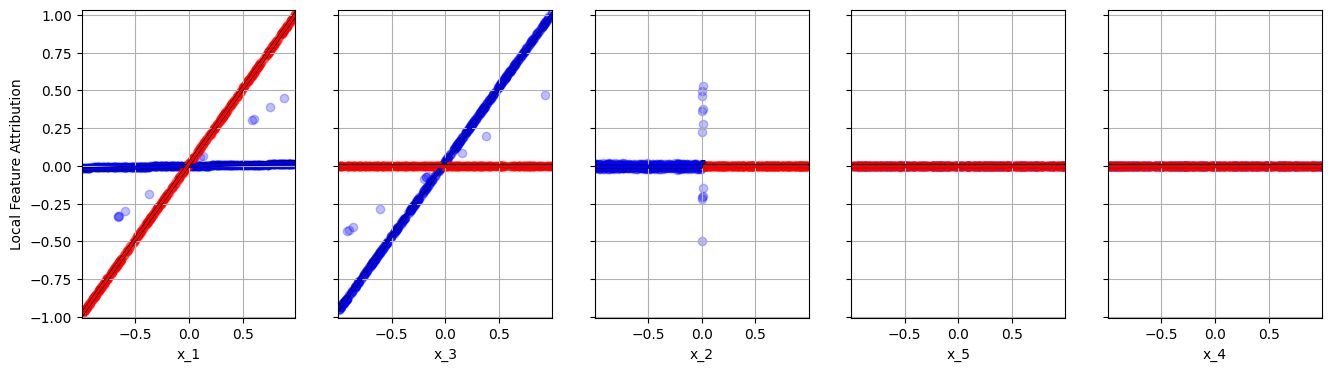

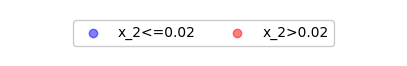

In [12]:
# Regional feature attributions
attrib_scatter_plot(regional_decompositions, regional_shapley_values, regional_backgrounds, features, figsize=(16, 4))
plot_legend(rules)